In [16]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import math
from statistics import mean, median
import time

In [70]:
file = "./tc3.csv"
data = pd.read_csv(file)



TCPdata = data[data["Protocol"]=="TCP"]
FTPdata = data[data["Protocol"]=="FTP"]


In [71]:
def plotCDF(inputList):
    num_bins = 10000
    counts, bin_edges = np.histogram (inputList, bins=num_bins, normed=True)
    cdf = np.cumsum (counts)
#     plt.plot (bin_edges[1:], cdf/cdf[-1],'-bD', markevery=markers_on)
    plt.plot (bin_edges[1:], cdf/cdf[-1])

## Part 1

In [72]:
SYNdata = TCPdata[TCPdata["Info"].str.contains("\[SYN\]")]
SYNdataDest = SYNdata[SYNdata["Info"].str.contains(">  21")]
UniqueServer = set(SYNdataDest["Destination"].unique().tolist())
UniqueClient = set(SYNdataDest["Source"].unique().tolist())
len(UniqueServer), len(UniqueClient)

(89, 510)

## Part 2

In [73]:
# data["SrcPort"] = data["Info"][data["Info"].str.extract(pat = '(\d+)  >  (\d+)')
tempList = TCPdata["Info"].tolist()
srcList = [string[:string.find("[")].strip().split('  >  ')[0] for string in tempList]
destList = [string[:string.find("[")].strip().split('  >  ')[1] for string in tempList]
srcList, destList
TCPdata["SrcPort"] = srcList
TCPdata["DestPort"] = destList
uniqueTCPflows = TCPdata.drop_duplicates(subset = ["Source", "Destination", "SrcPort", "DestPort"])
len(uniqueTCPflows)



/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


3280

## Part 3

Text(0.5, 1.0, 'TCP traffic profile')

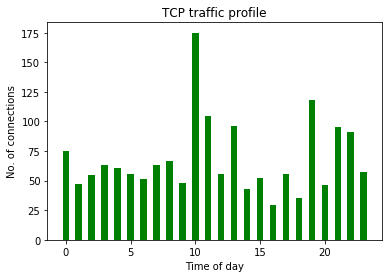

In [74]:
TCPfrequency = {}
for i in range(24):
    TCPfrequency[i] = 0
TCPflowsToServers = uniqueTCPflows[uniqueTCPflows["DestPort"]=="21"]
timeList = TCPflowsToServers["Time"].tolist()
timeList = [int(time // 3600) for time in timeList]
for time in timeList:
    TCPfrequency[time] += 1
TCPfrequency

plt.bar(TCPfrequency.keys(), TCPfrequency.values(), 0.5, color='g')
plt.xlabel('Time of day')
plt.ylabel('No. of connections')
plt.title('TCP traffic profile')

## Part 4 and 5

In [8]:
SYNdata = TCPdata[TCPdata["Info"].str.contains("\[SYN\]")]# | TCPdata["Info"].str.contains("\[FIN\]")]
SYNdata = SYNdata[SYNdata["Info"].str.contains(">  21")]
FINdata = TCPdata[TCPdata["Info"].str.contains("\[FIN, ACK\]")]# | TCPdata["Info"].str.contains("\[FIN\]")]
RSTdata = TCPdata[TCPdata["Info"].str.contains("\[RST\]")]# | TCPdata["Info"].str.contains("\[FIN\]")]



print(len(SYNdata), len(FINdata), len(RSTdata))

1667 2432 2117


In [9]:
timeList = []
ClientDataList = []              #sent by client
ServerDataList = []              #sent by server
FlowData = []
# for i in range(len(SYNdata)):
for i,row in SYNdata.iterrows():
#     startTime = SYNdata.iloc[i,1]
#     Src = SYNdata.iloc[i,2]
#     Dest = SYNdata.iloc[i,3]
#     SrcPort = SYNdata.iloc[i,7]
#     DestPort = SYNdata.iloc[i,8]
    startTime = row[1]
    Src = row[2]
    Dest = row[3]
    SrcPort = row[7]
    DestPort = row[8]

    validFIN1 = FINdata[(FINdata["Source"] == Src) & (FINdata["Destination"] == Dest) & (FINdata["SrcPort"] == SrcPort) & (FINdata["DestPort"] == DestPort) & (FINdata["Time"]>startTime)]
    validFIN2 = FINdata[(FINdata["Source"] == Dest) & (FINdata["Destination"] == Src) & (FINdata["SrcPort"] == DestPort) & (FINdata["DestPort"] == SrcPort) & (FINdata["Time"]>startTime)]
    validRST1 = RSTdata[(RSTdata["Source"] == Src) & (RSTdata["Destination"] == Dest) & (RSTdata["SrcPort"] == SrcPort) & (RSTdata["DestPort"] == DestPort) & (RSTdata["Time"]>startTime)]
    validRST2 = RSTdata[(RSTdata["Source"] == Dest) & (RSTdata["Destination"] == Src) & (RSTdata["SrcPort"] == DestPort) & (RSTdata["DestPort"] == SrcPort) & (RSTdata["Time"]>startTime)]
    
    validFrames =  pd.concat([validFIN1, validFIN2, validRST1, validRST2])
    
#     print(SYNdata.iloc[i])
    if(len(validFrames)==0):
        continue
    
    
    endTime = validFrames['Time'].min()

    ClientDataTable = TCPdata[(TCPdata["Source"] == Src) & (TCPdata["Destination"] == Dest) & (TCPdata["SrcPort"] == SrcPort) & (TCPdata["DestPort"] == DestPort) & (TCPdata["Time"]>=startTime) & (TCPdata["Time"]<=endTime)]
    ServerDataTable = TCPdata[(TCPdata["Source"] == Dest) & (TCPdata["Destination"] == Src) & (TCPdata["SrcPort"] == DestPort) & (TCPdata["DestPort"] == SrcPort) & (TCPdata["Time"]>=startTime) & (TCPdata["Time"]<=endTime)]
    
    
    flowTime = endTime - startTime
    ClientData = ClientDataTable['Length'].sum()
    ServerData = ServerDataTable['Length'].sum()


    
    timeList.append(flowTime)
    ClientDataList.append(ClientData)
    ServerDataList.append(ServerData)


#     print([flowTime, ClientData, ServerData])
    FlowData.append([flowTime, ClientData, ServerData])

    


KeyboardInterrupt: 

In [ ]:

# timeList = timeList[:math.ceil(len(timeList))]
plotCDF(timeList)
plt.xlim(0, 1000)
plt.ylim(0, 1)
plt.xlabel('Connection duration(sec)')
plt.ylabel('P(Connection Duration)<X')
plt.title('Connection Duration CDF')
# plt.plot(xs, ys, '-gD', markevery=markers_on)

print(median(timeList),mean(timeList))

In [ ]:
tempData = FlowData
tempData = FlowData[1:2000]
xData = [i[0] for i in tempData]
yData = [i[1] for i in tempData]

plt.xlim(0,2000)
plt.scatter(xData, yData)
plt.show()

print(np.corrcoef(xData, yData)[0, 1])

## Part 6 ... note that SYN data always sends to server

['21']
51.34636656216217 19.58248900000035


/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  This is separate from the ipykernel package so we can avoid doing imports until


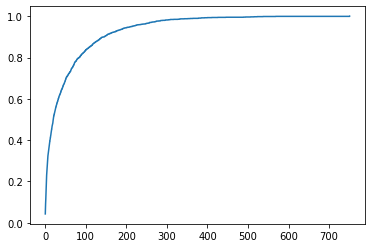

In [81]:
SYNdata = TCPdata[TCPdata["Info"].str.contains("\[SYN\]")]

print(SYNdata.DestPort.unique().tolist())#head(), end="\n\n")
# print(SYNdata.tail(), end="\n\n")

SYNinterArrivalTimes = SYNdata.Time.tolist()
# print(SYNinterArrivalTimes[:10], SYNinterArrivalTimes[-10:], end="\n\n")
SYNinterArrivalTimes = [SYNinterArrivalTimes[0]] + [SYNinterArrivalTimes[i+1]-SYNinterArrivalTimes[i] for i in range(len(SYNinterArrivalTimes)-1) ]
# print(SYNinterArrivalTimes[:10], SYNinterArrivalTimes[-10:], end="\n\n")
meanTime, medianTime = mean(SYNinterArrivalTimes), median(SYNinterArrivalTimes)
plotCDF(SYNinterArrivalTimes)
print(meanTime, medianTime)
SYNdata

SYNinterArrivalTimes.sort()

file1 = open("SYNarrival.txt","w+") 
for i in range(len(SYNinterArrivalTimes)):
    file1.write(str(SYNinterArrivalTimes[i])+"\n")
    if(SYNinterArrivalTimes[i]>300):
        break
file1.close() 


## Part 7

['21']
1.17464847025686 0.553568000004816


/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  This is separate from the ipykernel package so we can avoid doing imports until


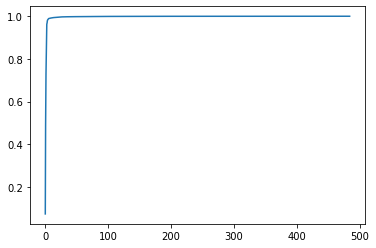

In [83]:
toServerData = TCPdata[TCPdata["DestPort"] == "21"]

print(SYNdata.DestPort.unique().tolist())#head(), end="\n\n")

serverInterArrivalTimes = toServerData.Time.tolist()
# print(serverInterArrivalTimes[0:30])
serverInterArrivalTimes = [serverInterArrivalTimes[0]] + [serverInterArrivalTimes[i+1]-serverInterArrivalTimes[i] for i in range(len(serverInterArrivalTimes)-1) ]
# print(serverInterArrivalTimes[0:30])


serverInterArrivalTimes = serverInterArrivalTimes[1:]
meanTime, medianTime = mean(serverInterArrivalTimes), median(serverInterArrivalTimes)
plotCDF(serverInterArrivalTimes)
print(meanTime, medianTime)

serverInterArrivalTimes.sort()
file1 = open("serverArrival.txt","w+") 
for i in range(len(serverInterArrivalTimes)):
    file1.write(str(serverInterArrivalTimes[i])+"\n")
    if(serverInterArrivalTimes[i]>7):
        break
file1.close() 

## Part 8 ... plot seperately

/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  This is separate from the ipykernel package so we can avoid doing imports until


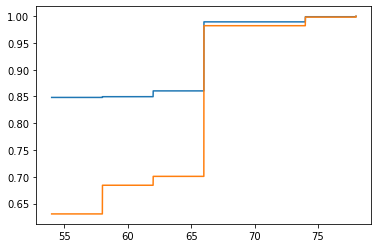

In [77]:
toServerData = TCPdata[TCPdata["DestPort"] == "21"]
fromServerData = TCPdata[TCPdata["SrcPort"] == "21"]


toServerLengths = toServerData.Length.tolist()
fromServerLengths = fromServerData.Length.tolist()

# toServerMeanTime, toServerMedianTime = mean(toServerLengths), median(toServerLengths)
# fromServerMeanTime, fromServerMedianTime = mean(fromServerLengths), median(fromServerLengths)

plotCDF(toServerLengths)
plotCDF(fromServerLengths)

In [78]:
#iterrows() -> 156.250s, for() -> 262.286s